In [1]:
# Imports
import os
import logging

import numpy as np
import pandas as pd

import skimage.measure as measure

import line_utils
import image_utils
import file_utils
import pca_utils

logger = logging.getLogger('pseudotime')
logging.basicConfig(
    filename='pseudotime_run.log',
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.DEBUG,
    datefmt='%Y-%m-%d %H:%M:%S')
# logger.addHandler(logging.StreamHandler())

In [2]:
targets = {}  # Start with an empty dictionary DO NOT DELETE

# Describe all of our target proteins here
# Any protein that does not have a specific workbook and image directory associated
# will be considered a general marker, available across all workbooks
targets["MTs"] = {"alias": ["aTub", "a-tub", "atub", "tub", "tub-m", "tub-rt"]}

targets["septin"] = {"alias": ["GFP"]}

targets["DAPI"] = {}

targets["RacGAP1"] = {
    "workbook": r"D:\Nadja Expansion Analysis\InstructionFiles\PCA\20250110_RacGAP1_along.xlsx",
    "workbook_sheet_name": "ToC",
    "workbook_header_row": 16,
    "image_directory": r"H:\RacGAP1",
}

targets["MKLP1"] = {
    "workbook": r"D:\Nadja Expansion Analysis\InstructionFiles\PCA\20250110_MKLP1_along_2024_only.xlsx",
    "workbook_sheet_name": "ToC",
    "workbook_header_row": 4,
    "image_directory": r"H:\MKLP1",
}


targets["anillin"] = {
    "workbook": r"D:\Nadja Expansion Analysis\InstructionFiles\PCA\20250110_anillin_along_2024_only.xlsx",
    "workbook_sheet_name": "ToC",
    "workbook_header_row": 2,
    "image_directory": r"H:\Anillin",
}

targets["myoIIA"] = {
    "workbook": r"D:\Nadja Expansion Analysis\InstructionFiles\PCA\20250114_myosinIIA_along.xlsx",
    "workbook_sheet_name": "ToC",
    "workbook_header_row": 0,
    "image_directory": r"H:\Myosin IIA",
}

targets["myoIIB"] = {
    "workbook": r"D:\Nadja Expansion Analysis\InstructionFiles\PCA\20250110_myoIIB_along.xlsx",
    "workbook_sheet_name": "ToC",
    "workbook_header_row": 1,
    "image_directory":  r"H:\Myosin IIB",
    "alias": ["mypoIIB", "myosinIIB"]
}

targets["Cit-K"] = {
    "workbook": r"D:\Nadja Expansion Analysis\InstructionFiles\PCA\20250110_CitK_along.xlsx",
    "workbook_sheet_name": "ToC",
    "workbook_header_row": 4,
    "image_directory":  r"H:\Citron Kinase",
}

targets["CellMask"] = {
    "workbook": r"D:\Nadja Expansion Analysis\InstructionFiles\PCA\20250114_CellMasko_2024_only.xlsx",
    "workbook_sheet_name": "ToC",
    "workbook_header_row": 1,
    "image_directory":  r"H:\CellMask Membrane",
}

targets["PRC1"] = {
   "workbook": r"D:\Nadja Expansion Analysis\InstructionFiles\PCA\20250110_PRC1_along.xlsx",
    "workbook_sheet_name": "ToC",
    "workbook_header_row": 1,
    "image_directory":  r"H:\PRC1",
}

targets["actin"] = {
    "workbook": r"D:\Nadja Expansion Analysis\InstructionFiles\PCA\20250114_Actin_profile.xlsx",
    "workbook_sheet_name": "ToC",
    "workbook_header_row": 1,
    "image_directory":  r"H:\Actin",
}

targets ["Septin7"] = {
    "workbook": r"D:\Nadja Expansion Analysis\InstructionFiles\PCA\20250114_Septin7_profileline.xlsx",
    "workbook_sheet_name": "ToC",
    "workbook_header_row": 0,
    "image_directory": r"H:\Septin7",
}

targets ["Septin11"] = {
    "workbook": r"D:\Nadja Expansion Analysis\InstructionFiles\PCA\20250114_Septin11_profileline.xlsx",
    "workbook_sheet_name": "ToC",
    "workbook_header_row": 0,
    "image_directory": r"H:\Septin11",
}

targets ["Septin9"] = {
    "workbook": r"D:\Nadja Expansion Analysis\InstructionFiles\PCA\20250114_Septin9_profileline.xlsx",
    "workbook_sheet_name": "ToC",
    "workbook_header_row": 0,
    "image_directory": r"H:\Septin9 Novus Bio",
}

targets ["BORG4"] = {
    "workbook": r"D:\Nadja Expansion Analysis\InstructionFiles\PCA\20250114_BORG4_profileline.xlsx",
    "workbook_sheet_name": "ToC",
    "workbook_header_row": 0,
    "image_directory": r"H:\BORG4",
}


targets ["IST1"] = {
    "workbook": r"D:\Nadja Expansion Analysis\InstructionFiles\PCA\20250203_IST1.xlsx",
    "workbook_sheet_name": "ToC",
    "workbook_header_row": 1,
    "image_directory": r"H:\IST1",
}

targets ["CHMP4B"] = {
    "workbook": r"D:\Nadja Expansion Analysis\InstructionFiles\PCA\20250203_CHMP4B.xlsx",
    "workbook_sheet_name": "ToC",
    "workbook_header_row": 0,
    "image_directory": r"H:\CHMP4B",
}

targets ["ALIXrb"] = {
    "workbook": r"D:\Nadja Expansion Analysis\InstructionFiles\PCA\20250114_ALIXrb.xlsx",
   "workbook_sheet_name": "ToC",
    "workbook_header_row": 0,
    "image_directory": r"H:\ALIX rb",
    "alias": ["ALIX"]
}

targets ["ALIXm"] = {
    "workbook": r"D:\Nadja Expansion Analysis\InstructionFiles\PCA\20250114_ALIXm.xlsx",
    "workbook_sheet_name": "Tabelle1",
    "workbook_header_row": 0,
    "image_directory": r"H:\ALIX m", 
}

targets ["Tsg101-ab83m"] = {
    "workbook": r"D:\Nadja Expansion Analysis\InstructionFiles\PCA\20250114_Tsg101_ab83.xlsx",
    "workbook_sheet_name": "ToC",
    "workbook_header_row": 1,
    "image_directory": r"H:\TSG101 ab83",
 
}

targets ["Tsg101"] = {
    "workbook": r"D:\Nadja Expansion Analysis\InstructionFiles\PCA\20250114_Tsg101.xlsx",
    "workbook_sheet_name": "ToC",
    "workbook_header_row": 0,
    "image_directory": r"H:\Tsg101",
    
}


# Order of time stages
time_key = "Frame"
n_time_bins = 6

# Channels per image (TODO: Auto detect)
n_ch = 4

# wavelengths to be found in the file names
# Sublists are grouped. First element of the sublist is a group name.
# NOTE: First element must be a number!
wvls = [488,[568, "orange"],[646,647,657]]

length = 500

# pixel sizes (we assume they are constant)
dx, dy, dz = 0.09, 0.09, 1

# What features should we perform PCA on?

features = ["diam_microtubule", 
            "diamA_micron",  
            "balance_microtubule",
            "balance_septin"]

In [3]:
# Go to each target's workbook and compute necessary additional metrics,
# including distance between septin rings, septin ring diameter, and
# microtubule bundle width.
for k, v in targets.items():
    try:
        logger.debug(f"Accessing {os.path.basename(v['workbook'])}")
    except KeyError:
        # Not a target with a workbook
        continue

    # Pre-cleaned metrics
    metrics = file_utils.load_workbooks({k: v})

    # Establish columns for septin peak locations (x_septin_1, x_septin_2) and distance between them (dx_septin)
    metrics['dx_septin'], metrics['x_septin_1'], metrics['x_septin_2'] = np.nan, np.nan, np.nan
    metrics['diamA_micron'] = 0
    
    for i, ml in metrics.iterrows():
        logger.debug(f"  Septin ring fit for {os.path.basename(ml['filename'])}")

        # Get the image associated with this row and load it with the channels sorted from high to low
        im = image_utils.NDImage(ml["filename"], load_sorted=True)

        # get x, y, angle for this row
        x, y, angle = ml[["X", "Y", "Angle"]]

        # find wavelengths in file name and sort from high to low
        wvls_dict, binned_wvls = image_utils.extract_channel_targets_from_filename(ml["filename"], wvls=wvls)

        # Establish target names in this data set and sort from high to low to match image load
        channel_targets = [wvls_dict[str(wvl)] for wvl in sorted(binned_wvls)[::-1]]

        # the last channel is always DAPI, if unknown
        if len(channel_targets) < n_ch:
            channel_targets.append("DAPI") 

        # --------- Fit septin peaks ---------

        # ... get the septin peaks
        mt_ch = [i for i, t in enumerate(channel_targets) if any([t == n for n in image_utils.target_names(targets, "MTs")])][0]
        septin_ch = [i for i, t in enumerate(channel_targets) if any([t == n for n in image_utils.target_names(targets, "septin")])][0]
        im_proj = im[:].mean(1).squeeze()
        p0, p1, dX2 = line_utils.find_septin_peaks(im_proj, x, y, angle, length,
                                                    mt_ch=mt_ch, 
                                                    septin_ch=septin_ch)

        metrics.loc[i,['x_septin_1','x_septin_2','dx_septin']] = [p0, p1, dX2]

        # --------- Get the number of occupied pixels in the MT profile ---------
        # This is important for distinguishing abscission from others
        xl, xu, yl, yu = line_utils.get_line_profile_endpoints(x, y, angle, length)

        chs = measure.profile_line(im_proj, [xl, yu], [xu, yl], linewidth=25)

        mt, septin = chs[:,mt_ch], chs[:,septin_ch]

        mt_norm = (mt-np.min(mt))/(np.max(mt)-np.min(mt))
        metrics.loc[i,'fill_microtubule'] = np.sum(mt_norm)/(length*25)

        # --------- Get the ratio of one side of the MT profile to the other ---------
        mt_mid = len(mt) // 2
        half1, half2 = mt_norm[:mt_mid].sum(), mt_norm[mt_mid:].sum()
        metrics.loc[i,'balance_microtubule'] = min(half1,half2)/max(half1,half2)

        # --------- Get the ratio of septin signal/mt signal ---------
        sm_min = min(np.min(septin), np.min(mt))
        sm_max = max(np.max(septin), np.max(mt))
        septin_norm = (septin-sm_min)/(sm_max-sm_min)
        mt_norm2 = (mt-sm_min)/(sm_max-sm_min)
        metrics.loc[i,'balance_septin'] = np.mean(septin_norm/(mt_norm2+1e-6))
        metrics.loc[i,'balance_septin2'] = np.mean(septin_norm**2/(mt_norm2+1e-6))

        # --------- Fit septin rings ---------
        p0x, p0y = line_utils.get_image_coordinate_from_distance_along_line(p0, xl, xu, yl, yu, len(septin))
        p1x, p1y = line_utils.get_image_coordinate_from_distance_along_line(p1, xl, xu, yl, yu, len(septin))

        # Now get the orthogonal line profile at the line center
        xl3, xu3, yl3, yu3 = line_utils.get_line_profile_endpoints(p0x, p0y, angle-90, length)
        chs = measure.profile_line(im_proj.T, [xl3, yu3], [xu3, yl3], linewidth=25)
        septin_ring0 = chs[:,septin_ch]

        ring0_diameter, res_lsq_ring0 = line_utils.fit_gaussian_fwhm(septin_ring0, return_dict=True)

        # Now get the orthogonal line profile at the line center
        xl4, xu4, yl4, yu4 = line_utils.get_line_profile_endpoints(p1x, p1y, angle-90, length)
        chs = measure.profile_line(im_proj.T, [xl4, yu4], [xu4, yl4], linewidth=25)
        septin_ring1 = chs[:,septin_ch]

        ring1_diameter, _ = line_utils.fit_gaussian_fwhm(septin_ring1, return_dict=True)

        metrics.loc[i,'diam_septin_ring'] = 0.5*(ring0_diameter + ring1_diameter)

        # --------- Fit center MT cross-section ---------
        # Now get the orthogonal line profile at the line center
        xl2, xu2, yl2, yu2 = line_utils.get_line_profile_endpoints(x, y, angle-90, length)
        chs = measure.profile_line(im_proj.T, [xl2, yu2], [xu2, yl2], linewidth=25)
        mt = chs[:,mt_ch]

        # Zach original
        # outer_diameter, res_lsq = line_utils.fit_tubule_diameter(mt, return_dict=True)
        # metrics.loc[i,'diam_microtubule'] = outer_diameter

        # outer diameter modified for Expansion Factor 24.04.2025
        outer_diameter, res_lsq = line_utils.fit_tubule_diameter(mt, return_dict=True)
        metrics.loc[i,'diam_microtubule'] = (outer_diameter) * (dx/metrics.loc[i,'EF'])


        # Get diamA_micron
        metrics.loc[i,'diamA_micron'] = (metrics.loc[i,'FWHM'] / 1000) * (dx/metrics.loc[i,'EF'])

    # TODO: Should the behaviour be replace or new?
    with pd.ExcelWriter(v['workbook'], mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
        metrics.to_excel(writer, sheet_name=f"{v['workbook_sheet_name']}_processed")

C:\Users\AG Ewers\AppData\Local\Temp\ipykernel_10564\3080954481.py:109: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.437891891891892' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  metrics.loc[i,'diamA_micron'] = (metrics.loc[i,'FWHM'] / 1000) * (dx/metrics.loc[i,'EF'])
C:\Users\AG Ewers\Documents\GitHub\expansion-analysis\line_utils.py:268: RuntimeWarning: overflow encountered in multiply
  return np.real((r*np.exp((-5*np.pi*(2j*r*t + 5*np.pi*sig**2))/(2.*r**2))*(12*spec.jv(1,5*np.pi)*(spec.erf((r*(r + t) - 5j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + spec.erf((r**2 - r*t + 5j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + (spec.erf((r**2 - r*t - 5j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + spec.erf((r*(r + t) + 5j*np.pi*sig**2)/(np.sqrt(2)*r*sig)))*np.exp((10j*np.pi*t)/r)) + 60*spec.jv(1,np.pi)*((spec.erf((r**2 - r*t - 1j*np.pi*sig**2)/(np.sqrt(2)*r*sig)) + spec.erf((r*(r + t) + 1

In [4]:
# Now let's go grab the new calculations
targets_processed = targets
for k, v in targets.items():
    try:
        targets_processed[k]["workbook_sheet_name"] = f"{v['workbook_sheet_name']}_processed"
        targets_processed[k]["workbook_header_row"] = 0
    except KeyError:
        continue

# Load aggregated data from workbooks
metrics = file_utils.load_workbooks(targets_processed)

C:\Users\AG Ewers\Documents\GitHub\expansion-analysis\file_utils.py:32: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  metrics = reduce(lambda  left,right: pd.merge(left, right, how='outer'), dfs)
C:\Users\AG Ewers\Documents\GitHub\expansion-analysis\file_utils.py:32: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  metrics = reduce(lambda  left,right: pd.merge(left, right, how='outer'), dfs)
C:\Users\AG Ewers\Documents\GitHub\expansion-analysis\file_utils.py:32: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  metrics = reduce(lambda  left,right: pd.merge(left, right, how='outer'), dfs)
C:\Users\AG Ewers\Documents\GitHub\expansion-analysis\file_utils.py:32: UserWarning: You are merging on int and float columns where the float values are not equal to their int represen

In [5]:
metrics[features]

,diam_microtubule,diamA_micron,balance_microtubule,balance_septin
0,1.457987,1.851142,0.705073,63.937263
1,0.905251,1.086904,0.869711,0.747263
2,1.013012,1.177500,0.860130,0.890121
3,1.064815,1.294562,0.975942,23.885643
4,1.221242,1.357418,0.083344,0.744983
...,...,...,...,...
1925,0.367765,0.106840,0.705450,0.883390
1926,0.259560,0.139520,0.387397,0.640045
1927,0.331045,0.161440,0.225110,35.215259
1928,2.277964,0.133940,0.241706,0.657557


In [6]:
# Compute PCA on the aggregated data and fit a polynomial through the space
pca, coords, fit = pca_utils.pca(metrics[features], transform=True, fit=True)

# Now add the PCA results as columns
xx, yy = coords
metrics["pca0"] = xx
metrics["pca1"] = yy

bins = pca_utils.sort_by_point_plane_dist(xx, yy, fit, nbins=n_time_bins)
for i, bin in enumerate(bins):
    # TODO: This only works because the merged metrics index matches the numerical index
    # Be careful
    metrics.loc[bins[i],time_key] = int(i)


C:\miniforge-pypy3\envs\expansion\Lib\site-packages\matplotlib\collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


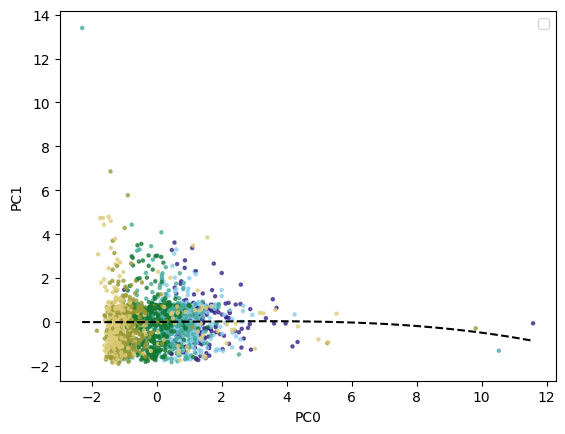

In [10]:
# Display the PCA results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1)

stage_keys = {v:k for k,v in enumerate(metrics["Stage"].unique())}
# stage_colors = [stage_keys[x] for x in metrics["Stage"]]



colors = {'A':'#DDCC77', 'BA':'#999933', 'CS':'#88CCEE', 'RC':'#332288',  'RS':'#44AA99', 'SM':'#117733' }
# colors = {'A':'#DDCC77', 'BA':'#999933', 'CS':'#FFFFFF', 'RC':'#FFFFFF',  'RS':'#44AA99', 'SM':'#117733' }

colors_ls = [colors[x] for x in metrics["Stage"]]

scatter = ax.scatter(xx, yy, c=colors_ls, s=5, alpha=0.7)
# scatter = ax.scatter(xx, yy, c=stage_colors, cmap='gist_rainbow_r', s=20)

xxx = np.linspace(np.min(xx),np.max(xx),100)
ax.plot(xxx, np.poly1d(fit)(xxx), linestyle='--', c='k')

dist, xp, yp = pca_utils.point_poly_dist(xx, yy, fit)
permutation = np.argsort(xp)

# for i in range(len(xp)):
#     ax.plot([xx[i], xp[i]], [yy[i], yp[i]], c='b', linewidth=0.5)

ax.legend(scatter.legend_elements(num=len(stage_keys)-1)[0],list(stage_keys.keys()))
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
# ax.set_xlim([-2,6])
# ax.set_ylim([-2,6])

fig.savefig('20250425_pca_color_s5_opacity7_EF_adjusted.svg')


In [8]:
# Show the features ranked from most important (left) to least important (right)
# per principle component (row number)
pd.DataFrame({f"feature{i}": k for i, k in enumerate(np.array(features)[np.argsort(np.abs(pca.components_),axis=1)[:,::-1]].T)})

,feature0,feature1,feature2,feature3
0,diamA_micron,diam_microtubule,balance_septin,balance_microtubule
1,balance_microtubule,balance_septin,diamA_micron,diam_microtubule


In [9]:
# Now map the features back onto their original files
for k, v in targets_processed.items():
    try:
        logger.debug(f"Accessing {os.path.basename(v['workbook'])}")
    except KeyError:
        # Not a target with a workbook
        continue

    # Pre-cleaned metrics
    metrics_processed = file_utils.load_workbooks({k: v})

    # Now merge in the PCA information
    metrics_merged = pd.merge(metrics_processed, metrics, how="left")

    # And write to file
    with pd.ExcelWriter(v['workbook'], mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
        metrics_merged.to_excel(writer, sheet_name=v['workbook_sheet_name'])

C:\Users\AG Ewers\AppData\Local\Temp\ipykernel_10564\4109381559.py:13: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  metrics_merged = pd.merge(metrics_processed, metrics, how="left")
C:\Users\AG Ewers\AppData\Local\Temp\ipykernel_10564\4109381559.py:13: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  metrics_merged = pd.merge(metrics_processed, metrics, how="left")
C:\Users\AG Ewers\AppData\Local\Temp\ipykernel_10564\4109381559.py:13: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  metrics_merged = pd.merge(metrics_processed, metrics, how="left")
C:\Users\AG Ewers\AppData\Local\Temp\ipykernel_10564\4109381559.py:13: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  metrics_merged = pd.merge(metr